# Rating Predictor for Yelp Reviews

In [15]:
# Import libraries
import requests
import json
import time
import pandas as pd
from bs4 import BeautifulSoup

## Scraper
Scrape review and restaurant data from Yelp API.

In [16]:
# Load API key from file 
with open('api_key.txt', 'r') as f:
    api_key = f.read().replace('\n','')

FileNotFoundError: [Errno 2] No such file or directory: 'api_key.txt'

In [17]:
def extract_info_for_business(row):
    return {'name': row['name'], 'id': row['id'], 'review_count': int(row['review_count']), 'url': row['url']}

def scrape_restaurant_list(location):
    # Comment for method    
    payload = {'categories': 'restaurants', 'location': location, 'limit': 20, 'offset': 0}
    basic_url = 'https://api.yelp.com/v3/businesses/search'
    headers = {'Authorization': 'Bearer ' + api_key}
    response = requests.get(basic_url, params=payload, headers=headers)
    res_json = response.json()
    total = res_json['total']
    print("total: ", total)
    businesses_list = list(map(extract_info_for_business, res_json['businesses']))
    while len(businesses_list) < total:
        print(len(businesses_list))
        time.sleep(0.3)
        payload['offset'] = len(businesses_list)
        response = requests.get(basic_url, params=payload, headers=headers)
        res_json = response.json()
        if 'businesses' not in res_json or len(list(res_json['businesses'])) == 0:
            break
        businesses_list.extend(list(map(extract_info_for_business ,res_json['businesses'])))
    
    return businesses_list
    

In [18]:
blist = scrape_restaurant_list('94043')
# print(blist)
print(len(blist))

NameError: name 'api_key' is not defined

In [19]:
print(blist[:10])

NameError: name 'blist' is not defined

Get reviews

In [32]:
def parse_page(html):
    """
    Parse the reviews on a single page of a restaurant.
    
    Args:
        html (string): String of HTML corresponding to a Yelp restaurant

    Returns:
        tuple(list, string): a tuple of two elements
            first element: list of dictionaries corresponding to the extracted review information
            second element: URL for the next page of reviews (or None if it is the last page)
    """
    review_list = []
    soup = BeautifulSoup(html, 'html.parser')
    for review_block in soup.find_all('div', attrs={'class': 'review review--with-sidebar'}):
        review_id = user_id = rating = date = text = None
        if 'data-review-id' in review_block.attrs:
            review_id = review_block['data-review-id']
        if 'data-signup-object' in review_block.attrs and review_block['data-signup-object'].startswith('user_id:'):
            user_id = review_block['data-signup-object'][8:]
        rating_div = review_block.find('div', attrs={'class': 'i-stars'})
        if 'title' in rating_div.attrs:
            rating = float(rating_div['title'].split()[0])
        date_span = review_block.find('span', attrs={'class': 'rating-qualifier'})
        if date_span:
            date = date_span.getText().strip()
        review_content = review_block.find('div', attrs={'class': 'review-content'})
        if review_content:
            text = review_content.find('p').getText()
        if review_id and user_id and rating and date and text:
            review_list.append({
                'review_id': review_id,
                'user_id': user_id,
                'rating': rating,
                'date': date,
                'text': text
            })
    next_link = None
    next_ele = soup.find('a', attrs={'class': 'u-decoration-none next pagination-links_anchor'})
    if next_ele and 'href' in next_ele.attrs:
        next_link = next_ele['href']
    return review_list, next_link

In [53]:
def scrape_all_reviews(restaurants):
    for i, restaurant in enumerate(restaurants):
        print("restaurant: ", i)
        reviews = []
        url = restaurant['url']
        while url != None:
            response = requests.get(url)
            reviews_in_page, url = parse_page(response.content)
            reviews.extend(reviews_in_page)
        print(len(reviews))
        df = pd.DataFrame(reviews)
        df.to_csv('reviews.csv', mode='a', header=True)

In [ ]:
scrape_all_reviews(blist[42:])

restaurant:  0
990
restaurant:  1
618
restaurant:  2
440
restaurant:  3
801
restaurant:  4
552
restaurant:  5
1213
restaurant:  6
661
restaurant:  7
482
restaurant:  8
697
restaurant:  9
1183
restaurant:  10
1382
restaurant:  11
1044
restaurant:  12
1423
restaurant:  13
647
restaurant:  14
671
restaurant:  15
1150
restaurant:  16
574
restaurant:  17
150
restaurant:  18
1227
restaurant:  19
442
restaurant:  20
511
restaurant:  21
629
restaurant:  22
703
restaurant:  23
992
restaurant:  24
424
restaurant:  25
193
restaurant:  26
851
restaurant:  27
349
restaurant:  28
1177
restaurant:  29
449
restaurant:  30
1246
restaurant:  31
863
restaurant:  32
1189
restaurant:  33
420
restaurant:  34
623
restaurant:  35
1490
restaurant:  36
612
restaurant:  37
402
restaurant:  38
479
restaurant:  39
913
restaurant:  40
552
restaurant:  41
576
restaurant:  42
931
restaurant:  43
600
restaurant:  44
342
restaurant:  45
721
restaurant:  46
434
restaurant:  47
911
restaurant:  48
286
restaurant:  49
185

3


## Feature Extraction

In [20]:
# df = pd.read_csv(open('reviews.csv','rU'), header = None)
df = pd.read_csv(open('reviews.csv','rU'))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


In [21]:
# df['length'] = df.text.str.len()
# print(df)
def pre_process(df):
    new_df = df
    # Extract reviews and ratings
    new_df = new_df[['text', 'rating']]
    
    # remove invalid rows with ",text,rating"
    new_df = new_df[new_df.rating.astype(str).str.contains("rating") == False]

    # convert rating values to float
    new_df['rating'] = new_df['rating'].astype(float).fillna(0)
    # add length column to record word count of reviews
    new_df['length'] = new_df['text'].astype(str).apply(word_count)
    print(new_df.iloc[0].length)
    
    # remove punctations
    
    return new_df
    
def word_count(str):
    return len(str.split())

df = pre_process(df)
print(df)

133
                                                     text  rating  length
0       Had an amazing four course dinner here! 1. Wil...     5.0     133
1       A Saturday date night with my boyfriend - and ...     4.0     112
2       Was able to get a seat at the bar at 1700 with...     5.0      57
3       Tasting menu here is delicious! Alexander's pa...     4.0      15
4       One of the best fine dining restaurants I've b...     5.0     233
5       First, I must confess we had no business being...     4.0     146
6       Good food, good service, pricey but for an occ...     4.0     444
7       Having been to the Steakhouse in Cupertino, I ...     4.0     409
8       Made a reservation the day before and came her...     4.0     303
9       ** Upscale restaurant with both steak and seaf...     4.0     199
10      This review is for a catered event our company...     2.0     178
11      Excellent service and good ambiance makes this...     4.0      70
12      The food here was so good!

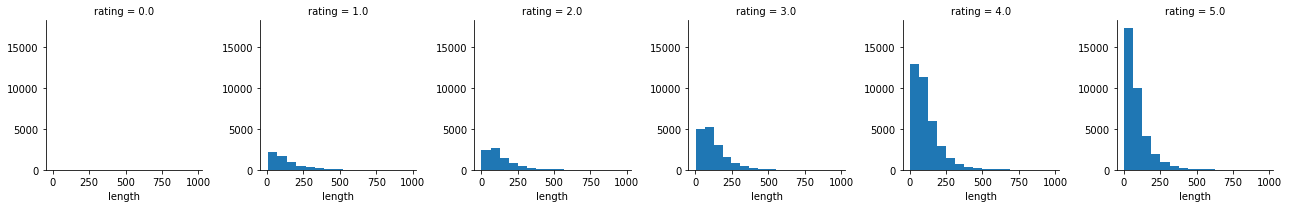

In [22]:
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

g = sns.FacetGrid(data=df, col='rating')
g.map(plt.hist, 'length', bins=25)
plt.show()

In [25]:
five = df[(df.rating >= 1.0)]
# print(binary)
X = five.text
y = five.rating

import string

# remove stopwords, punctuations, to lower case
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)



In [29]:
import pickle

filehandler = open('bow_transformer', 'wb')
pickle.dump(bow_transformer, filehandler)
filehandler.close()


In [ ]:
filehandler = open('bow_transformer', 'rb')
bow_transformer = pickle.load(filehandler)
filehandler.close()

In [80]:
binary = df[(df.rating == 1.0) | (df.rating == 5.0)]
# print(binary)
X = binary.text
y = binary.rating

import string
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

from sklearn.feature_extraction.text import CountVectorizer
bow_transformer_binary = CountVectorizer(analyzer=text_process).fit(X)


In [ ]:
filehandler = open('bow_transformer_binary', 'wb')
pickle.dump(bow_transformer_binary, filehandler)
filehandler.close()

In [31]:
review_25 = X.iloc[54]
print(review_25)
bow_25 = bow_transformer.transform([review_25])
print(bow_25)

To be honest, I think Alexander's Steakhouse should just stick to what they do best, making excellent juicy steaks. I came here to take my mom out to a nice Mother's Day meal. I wasn't too impressed with the seafood entree options. Here is a breakdown of what we ordered:Appetizers:- Lobster Rocks: This was my 2nd favorite dish out of the whole meal! It's tempura fried lobster tossed in squid ink (hence why it's black as "rocks"). Super delicious and highly recommend- Grilled Octopus: Soft and tender but nothing too surprising. - Hamachi shot: We only ordered one to share with me and my mom but it was delicious! Also highly recommend. Entrees: So we actually wanted to order the Black Sea Bass but it was sold out. Since there wasn't that many options to choose from, we decided to order two Seared Mero prepared two different ways, one Sea Bass way and one regular way. We also ordered the Flat Iron Wagyu Steak. My family all agree that the Mero prepared the Sea Bass was much better than th

In [32]:
X_ = bow_transformer.transform(X)

In [35]:
print(X_)

filehandler = open('X_', 'wb')
pickle.dump(X_, filehandler)
filehandler.close()

  (0, 132)	1
  (0, 4744)	1
  (0, 5910)	1
  (0, 6696)	1
  (0, 9132)	1
  (0, 14114)	1
  (0, 19919)	1
  (0, 20160)	1
  (0, 23353)	1
  (0, 24013)	2
  (0, 25158)	1
  (0, 29382)	1
  (0, 29614)	1
  (0, 40170)	1
  (0, 43989)	1
  (0, 44811)	1
  (0, 45184)	1
  (0, 48568)	1
  (0, 49456)	2
  (0, 49492)	1
  (0, 52019)	1
  (0, 54195)	2
  (0, 54447)	1
  (0, 55023)	1
  (0, 58656)	1
  :	:
  (102567, 167766)	1
  (102567, 168712)	1
  (102567, 170214)	1
  (102567, 171747)	1
  (102567, 180759)	1
  (102567, 183414)	1
  (102567, 187090)	1
  (102567, 190039)	1
  (102567, 193930)	1
  (102568, 37115)	1
  (102568, 54195)	1
  (102568, 78127)	1
  (102568, 79322)	1
  (102568, 81826)	1
  (102568, 84335)	1
  (102568, 98449)	1
  (102568, 104005)	1
  (102568, 111660)	1
  (102568, 115679)	1
  (102568, 130796)	1
  (102568, 132128)	1
  (102568, 132238)	1
  (102568, 146994)	1
  (102568, 152273)	1
  (102568, 158047)	1


In [36]:
X_ = 0

filehandler = open('X_', 'rb')
X_ = pickle.load(filehandler)
filehandler.close()

print(X_)

  (0, 132)	1
  (0, 4744)	1
  (0, 5910)	1
  (0, 6696)	1
  (0, 9132)	1
  (0, 14114)	1
  (0, 19919)	1
  (0, 20160)	1
  (0, 23353)	1
  (0, 24013)	2
  (0, 25158)	1
  (0, 29382)	1
  (0, 29614)	1
  (0, 40170)	1
  (0, 43989)	1
  (0, 44811)	1
  (0, 45184)	1
  (0, 48568)	1
  (0, 49456)	2
  (0, 49492)	1
  (0, 52019)	1
  (0, 54195)	2
  (0, 54447)	1
  (0, 55023)	1
  (0, 58656)	1
  :	:
  (102567, 167766)	1
  (102567, 168712)	1
  (102567, 170214)	1
  (102567, 171747)	1
  (102567, 180759)	1
  (102567, 183414)	1
  (102567, 187090)	1
  (102567, 190039)	1
  (102567, 193930)	1
  (102568, 37115)	1
  (102568, 54195)	1
  (102568, 78127)	1
  (102568, 79322)	1
  (102568, 81826)	1
  (102568, 84335)	1
  (102568, 98449)	1
  (102568, 104005)	1
  (102568, 111660)	1
  (102568, 115679)	1
  (102568, 130796)	1
  (102568, 132128)	1
  (102568, 132238)	1
  (102568, 146994)	1
  (102568, 152273)	1
  (102568, 158047)	1


## Train the Model

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=101)

### Train by naive bayes

In [38]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [53]:
print(nb.get_params())
print(X_test.shape[0])
print((nb.predict_log_proba(X_test)).shape[0])
print(nb.predict_proba(X_test))

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}
30771
30771
[[  9.24874219e-08   1.24937665e-05   7.40077841e-03   9.59162946e-01
    3.34236889e-02]
 [  1.22020291e-23   1.38762562e-15   1.60536409e-07   1.62801380e-01
    8.37198459e-01]
 [  1.58398813e-08   1.46508117e-05   6.98680307e-03   4.37674256e-01
    5.55324274e-01]
 ..., 
 [  2.75175264e-01   2.27358091e-01   2.41369462e-01   1.99769031e-01
    5.63281526e-02]
 [  1.60504473e-89   4.60054631e-57   6.14049072e-28   2.47533030e-03
    9.97524670e-01]
 [  2.05082303e-10   1.94983610e-10   5.09738566e-09   4.57834406e-05
    9.99954211e-01]]


### Predict

In [39]:
preds = nb.predict(X_test)

In [57]:
print(preds)

[ 4.  5.  5. ...,  1.  5.  5.]


In [75]:
pred_1 = [preds[index] for index, value in enumerate(y_test) if value == 1.0]
pred_1_avg = np.mean(pred_1)
print(len(pred_1))
pred_2 = [preds[index] for index, value in enumerate(y_test) if value == 2.0]
pred_2_avg = np.mean(pred_2)
print(len(pred_2))
pred_3 = [preds[index] for index, value in enumerate(y_test) if value == 3.0]
pred_3_avg = np.mean(pred_3)
print(len(pred_3))
pred_4 = [preds[index] for index, value in enumerate(y_test) if value == 4.0]
pred_4_avg = np.mean(pred_4)
print(len(pred_4))
pred_5 = [preds[index] for index, value in enumerate(y_test) if value == 5.0]
pred_5_avg = np.mean(pred_5)
print(len(pred_5))

pred_avg = [pred_1_avg, pred_2_avg, pred_3_avg, pred_4_avg, pred_5_avg]
print(pred_avg)




1807
2542
5030
10702
10690
[2.4084117321527394, 3.2521636506687646, 3.7240556660039763, 4.2156606241823962, 4.6597754911131899]


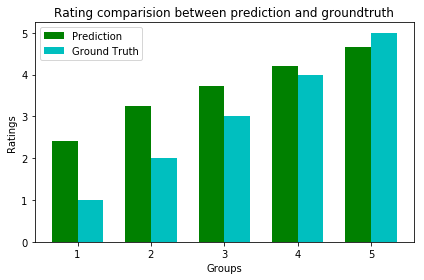

In [79]:
fig, ax = plt.subplots()

n_groups = 5

means_men = pred_avg
means_women = [1,2,3,4,5]

index = np.arange(n_groups)
bar_width = 0.35

error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, means_men, bar_width,color='g', label='Prediction')

rects2 = ax.bar(index + bar_width, means_women, bar_width, color='c', label='Ground Truth')

ax.set_xlabel('Groups')
ax.set_ylabel('Ratings')
ax.set_title('Rating comparision between prediction and groundtruth')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('1', '2', '3', '4', '5'))
ax.legend()

fig.tight_layout()
plt.savefig("prediction.png")
plt.show()

50


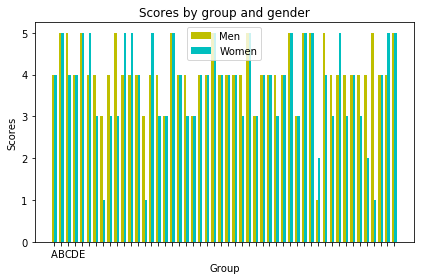

In [68]:
fig, ax = plt.subplots()

n_groups = 50

means_men = preds[:50]
print(len(means_men))


means_women = y_test[:50]


index = np.arange(n_groups)
bar_width = 0.35

error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, means_men, bar_width,color='y', label='Men')

rects2 = ax.bar(index + bar_width, means_women, bar_width, color='c', label='Women')

ax.set_xlabel('Group')
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('A', 'B', 'C', 'D', 'E'))
ax.legend()

fig.tight_layout()
plt.show()

### Evaluate

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds)) 

[[ 656  290  432  325  104]
 [ 192  217 1050  924  159]
 [  64   95 1316 3245  310]
 [  33   30  369 7434 2836]
 [  17   13   66 3398 7196]]


             precision    recall  f1-score   support

        1.0       0.68      0.36      0.47      1807
        2.0       0.34      0.09      0.14      2542
        3.0       0.41      0.26      0.32      5030
        4.0       0.49      0.69      0.57     10702
        5.0       0.68      0.67      0.68     10690

avg / total       0.54      0.55      0.52     30771



In [45]:
print(len(preds[preds == 1.0]))
print(len(preds[preds == 2.0]))
print(len(preds[preds == 3.0]))
print(len(preds[preds == 4.0]))
print(len(preds[preds == 5.0]))

import numpy as np
y_test_ = np.array(y_test.tolist())
print(len(y_test_[y_test_ == 1.0]))
print(len(y_test_[y_test_ == 2.0]))
print(len(y_test_[y_test_ == 3.0]))
print(len(y_test_[y_test_ == 4.0]))
print(len(y_test_[y_test_ == 5.0]))

import numpy as np
print(np.average(np.absolute(preds - y_test)))

962
645
3233
15326
10605
1807
2542
5030
10702
10690
0.559000357479


## SVM

In [54]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

print(clf.predict(X_test))

[ 4.  4.  4. ...,  4.  4.  4.]
